# Text classification of positive & negative reviews for skincare products

## Yura Ueno

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Data Loading & Data selection

The data used for this project is downloaded from: https://www.kaggle.com/datasets/nadyinky/sephora-products-and-skincare-reviews/data?select=reviews_0-250.csv

This dataset was collected via Python scraper in March 2023 and contains:

- user reviews from the Skincare category, including user appearances, review ratings, and whether the review is recommending the product or not.

We use this dataset to carry out a sentiment classification of the reviews into "recommending" (positive) and "not recommending" (negative) reviews.


In [2]:
df_org = pd.read_csv("reviews_0-250.csv", index_col=0)

In [3]:
df_org.head()

,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
3,6083038851,5,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time...,Can't go wrong with any of them,NaN,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
4,47056667835,5,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must h...",A must have !!!,light,hazel,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0


In [4]:
df_org.columns

Index(['author_id', 'rating', 'is_recommended', 'helpfulness',
       'total_feedback_count', 'total_neg_feedback_count',
       'total_pos_feedback_count', 'submission_time', 'review_text',
       'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color',
       'product_id', 'product_name', 'brand_name', 'price_usd'],
      dtype='object')

In [5]:
# select only the relevant collumns
df_prep = df_org[["review_text", "is_recommended"]]
df_prep.dropna(inplace=True)
df_prep.head()

,review_text,is_recommended
0,I use this with the Nudestix “Citrus Clean Bal...,1.0
1,I bought this lip mask after reading the revie...,0.0
2,My review title says it all! I get so excited ...,1.0
3,I’ve always loved this formula for a long time...,1.0
4,"If you have dry cracked lips, this is a must h...",1.0


In [6]:
# check if there are any duplicates in the data
df_prep["review_text"].duplicated().sum()

84791

In [7]:
# drop duplicates in the data
df_prep.drop_duplicates(subset=["review_text"], inplace=True)

In [8]:
# check the number of postivie and negative reviews
df_prep["is_recommended"].value_counts()

1.0    335431
0.0     63423
Name: is_recommended, dtype: int64

=> will use only 20,000 positive reviews and 20,000 negative reviews in order to create a balanced dataset and also considering that around 40,000 reviews would be sufficient for this sentiment classification project.

In [9]:
# select 20,000 negative reviews
df_neg = df_prep[df_prep["is_recommended"]==0].reset_index(drop=True).iloc[:20000].copy()
df_neg

,review_text,is_recommended
0,I bought this lip mask after reading the revie...,0.0
1,I’ll give this 2 stars for nice packaging and ...,0.0
2,Honestly I was so excited when I got this in t...,0.0
3,Does the gummy bear mask smell absolutely deli...,0.0
4,There’s nothing wrong with it but i think it w...,0.0
...,...,...
19995,NOT FOR OILY SKIN!!! I really wanted to like t...,0.0
19996,Really weird texture. Good if you want a matte...,0.0
19997,"I am not 100% sure which ingredient did it, bu...",0.0
19998,This sunscreen is disgusting and I gave it to ...,0.0


In [10]:
# select 20,000 positive reivews
df_pos = df_prep[df_prep["is_recommended"]==1].reset_index(drop=True).iloc[:20000].copy()
df_pos

,review_text,is_recommended
0,I use this with the Nudestix “Citrus Clean Bal...,1.0
1,My review title says it all! I get so excited ...,1.0
2,I’ve always loved this formula for a long time...,1.0
3,"If you have dry cracked lips, this is a must h...",1.0
4,The scent isn’t my favourite but it works grea...,1.0
...,...,...
19995,I have been struggling with dark spots for the...,1.0
19996,This product is awesome! I only got 3 days wor...,1.0
19997,"Dr. Dennis Gross Skincare is abit pricy ,howev...",1.0
19998,"With having extremely sensitive skin and eyes,...",1.0


#### Check the languages of the reviews

In [11]:
from langdetect import detect

In [12]:
df_pos["review_lang"] = df_pos["review_text"].apply(detect)

In [13]:
df_neg["review_lang"] = df_neg["review_text"].apply(detect)

In [14]:
df_pos["review_lang"].value_counts()

en    19839
fr       95
no       19
af       10
de        7
da        7
es        5
ro        3
tl        2
it        2
ca        2
sv        2
et        2
so        1
sq        1
cy        1
nl        1
sl        1
Name: review_lang, dtype: int64

In [15]:
df_neg["review_lang"].value_counts()

en    19935
fr       30
af       15
no        7
da        4
pt        3
sv        2
de        1
it        1
sq        1
ro        1
Name: review_lang, dtype: int64

=> will limit to only English reviews and also limit the number of the reviews to be 19,800 for positive and negative reviews each so that we have a balanced dataset.

In [16]:
df_pos = df_pos[df_pos["review_lang"]=="en"].reset_index(drop=True).iloc[:19800].copy()

In [17]:
df_neg = df_neg[df_neg["review_lang"]=="en"].reset_index(drop=True).iloc[:19800].copy()

In [18]:
df = pd.concat([df_pos, df_neg]).copy()

In [19]:
df["review_lang"].value_counts()

en    39600
Name: review_lang, dtype: int64

In [20]:
df["is_recommended"].value_counts()

1.0    19800
0.0    19800
Name: is_recommended, dtype: int64

In [21]:
df

,review_text,is_recommended,review_lang
0,I use this with the Nudestix “Citrus Clean Bal...,1.0,en
1,My review title says it all! I get so excited ...,1.0,en
2,I’ve always loved this formula for a long time...,1.0,en
3,"If you have dry cracked lips, this is a must h...",1.0,en
4,The scent isn’t my favourite but it works grea...,1.0,en
...,...,...,...
19795,I didn’t like the feel or smell of this sunscr...,0.0,en
19796,I thought this sunscreen was a clean product. ...,0.0,en
19797,The consistency of this product is so weird. I...,0.0,en
19798,I got a sample size with purchase. It’s very ...,0.0,en


### Split the dataset into train and test dataset

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X = df["review_text"].values

In [24]:
y = df["is_recommended"].values

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [26]:
from collections import Counter

In [27]:
Counter(y_train)

Counter({1.0: 15840, 0.0: 15840})

In [28]:
Counter(y_test)

Counter({0.0: 3960, 1.0: 3960})

# Data preprocessing

In the original data, each instance contains a review and its class label (0 for not recommended and 1 for recommended). We converted the comments to a sparse matrix of TF-IDF features using sklearn's TfidfVectorizer(). TF-IDF (Term Frequency Inverse Document Frequency) is a numeric statistic which is expected to reflect the importance of a term in a document in a collection/corpus. TF-IDF is calulcated as follows: tfidf(t,D) = tf(t,D)・log((1+N)/(1+df(t))), where tf(t,D) is the count of word t in document D and df(t) is the number of documents containing t. As can be seen in the equation, TF-IDF down-weights words that occur in many doccuments (e.g. "the", "a", "is") since those words carry little meaningful information about the actual contents of the document. Using TF-IDF, each review is represented as a numerical feature vector that indicates the tf-idf weighted frequency of terms.

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [30]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
feature_names = tfidf.get_feature_names_out()

# Model Training

## Hyperparameter tuning

Linear SVC has a hyperparameter C, which is used to set the amount of regularization. We tuned the hyperparameter C through grid serach using GridseachCV from sklearn. Since the dataset used in this project is well-balanced between the two classes, and there is no preference between prioritizing correct classification of positive or negative reviews, we chose the C value that yields the highest accuracy. We first tried setting C as 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0, 1000000000.0, and 10000000000.0. After the first round of grid search, the linear SVC seemed to have higher accuracy when C was around 0.1~10, we conducted the second round of grid search with C set to 0.1, 0.316, 1.0, 3.16, and 10.0. As a result, the linear SVC had higher accuracy when C was between 0.2 and 0.7. Therefore, we conducted the final grid search with C set to 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, and 0.8, resulting in the highest accuracy with C=0.3. Therefore, we chose 0.3 as the final value of C. 

In [31]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

In [32]:
param_grid = {'C':np.logspace(-2, 10, 13)}
grid_linear = GridSearchCV(LinearSVC(),param_grid, cv=5, n_jobs=-1)
grid_linear.fit(X_train_tfidf,y_train)

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10])})

In [33]:
summary = pd.DataFrame(
    [grid_linear.cv_results_['param_C'], grid_linear.cv_results_['mean_test_score'].round(4),
     grid_linear.cv_results_['rank_test_score']]).T.rename(columns={0:'C',1:'Accuracy', 2:'Ranking'})
summary['C'] = summary['C'].map('{:.2f}'.format)
summary

,C,Accuracy,Ranking
0,0.01,0.8972,4.0
1,0.10,0.9229,1.0
2,1.00,0.9226,2.0
3,10.00,0.9062,3.0
4,100.00,0.8789,5.0
5,1000.00,0.8641,6.0
6,10000.00,0.8609,11.0
7,100000.00,0.8606,12.0
8,1000000.00,0.8620,8.0
9,10000000.00,0.8619,9.0


The classifier seemed to perform well when C was around 0.1~10. Therefore, will grid search C around that range.

In [34]:
param_grid = { 'C':np.logspace(-1, 1, 13)}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid_linear = GridSearchCV(LinearSVC(),param_grid, cv=cv, n_jobs=-1)
grid_linear.fit(X_train_tfidf,y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': array([ 0.1       ,  0.14677993,  0.21544347,  0.31622777,  0.46415888,
        0.68129207,  1.        ,  1.46779927,  2.15443469,  3.16227766,
        4.64158883,  6.81292069, 10.        ])})

In [35]:
pd.DataFrame(
    [grid_linear.cv_results_['param_C'], grid_linear.cv_results_['mean_test_score'].round(4),
     grid_linear.cv_results_['rank_test_score']]).T.rename(columns={0:'C',1:'Accuracy', 2:'Ranking'})

,C,Accuracy,Ranking
0,0.100000,0.9248,5.0
1,0.146780,0.9257,2.0
2,0.215443,0.9257,2.0
3,0.316228,0.9260,1.0
4,0.464159,0.9257,4.0
5,0.681292,0.9242,6.0
6,1.000000,0.9222,7.0
7,1.467799,0.9207,8.0
8,2.154435,0.9190,9.0
9,3.162278,0.9158,10.0


The classifier seems to perform better when C is around 0.2 ~ 0.7. We will further grid search the C in that range.

In [36]:
param_grid = { 'C':np.arange(0.2,0.8,0.1)}
grid_linear = GridSearchCV(LinearSVC(max_iter=10000),param_grid, cv=5, n_jobs=-1)
grid_linear.fit(X_train_tfidf,y_train)

GridSearchCV(cv=5, estimator=LinearSVC(max_iter=10000), n_jobs=-1,
             param_grid={'C': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])})

In [37]:
pd.DataFrame(
    [grid_linear.cv_results_['param_C'], grid_linear.cv_results_['mean_test_score'].round(5),
     grid_linear.cv_results_['rank_test_score']]).T.rename(columns={0:'C',1:'Accuracy', 2:'Ranking'})

,C,Accuracy,Ranking
0,0.2,0.92446,4.0
1,0.3,0.92541,1.0
2,0.4,0.92484,2.0
3,0.5,0.92481,3.0
4,0.6,0.92434,5.0
5,0.7,0.92390,6.0
6,0.8,0.92371,7.0


Although there is not much difference in accuracy among the different values of C between 0.2 and 0.8, C = 0.3 seems to be the best. So now we will conduct cross-validation with C=0.3 and check average accuracy, f1 score, precision, and recall to observe over all performance of the model on training data.

In [38]:
from sklearn.model_selection import cross_validate

In [39]:
svc = LinearSVC(C=0.3)

In [40]:
cv_score = cross_validate(svc, X_train_tfidf, y_train, cv=5, scoring=('accuracy', 'f1', 'precision', 'recall'))

In [41]:
print("Average Accuracy: ", np.mean(cv_score['test_accuracy']))
print("Average F1: ", np.mean(cv_score['test_f1']))
print("Average Precision: ", np.mean(cv_score['test_precision']))
print("Average Recall: ", np.mean(cv_score['test_recall']))

Average Accuracy:  0.924810606060606
Average F1:  0.9243604836921773
Average Precision:  0.9299166255291098
Average Recall:  0.9188762626262627


The result of the cross-validation shows that the model has fairly high average accuracy of 0.925 and fairly high average f1 score of 0.924. The average precision and recall are about the same, indicating that the model classifies both positive and negative reviews equally well.

## Model Training with the Tuned Hyperparameter C=0.5

In [67]:
svc = LinearSVC(C=0.3)

In [68]:
svc.fit(X_train_tfidf, y_train)

LinearSVC(C=0.3)

# Model Evaluation

We evaluate the performance of the trained model using accuracy as the data is well-balanced between the two classes and there is no preference between prioritizing correct classifications of positive or negative reviews in this project.

## Testing the trained model on the test data

In [44]:
y_hat = svc.predict(X_test_tfidf)

## The Test Accuracy

In [45]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_hat).round(4))

Accuracy: 0.9274


## Confusion Matrix

In [46]:
from sklearn.metrics import confusion_matrix

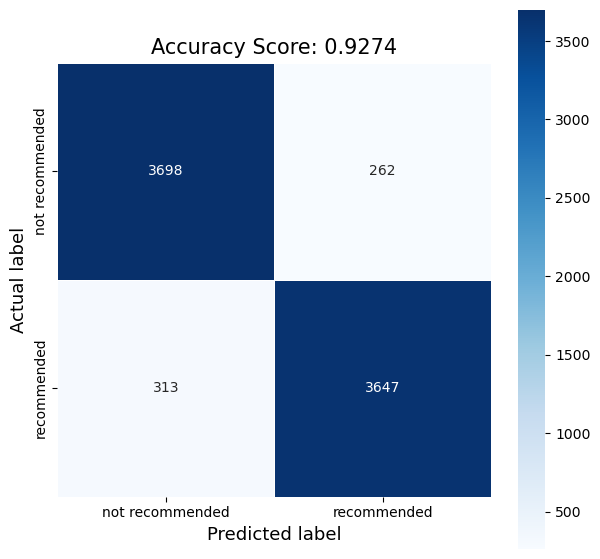

In [47]:
score = accuracy_score(y_test, y_hat)
cm = confusion_matrix(y_test, y_hat)
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, linewidths=.5, square = True, cmap = 'Blues',
            xticklabels=['not recommended', 'recommended'], yticklabels=['not recommended', 'recommended'], fmt="d")
plt.ylabel('Actual label', size=13)
plt.xlabel('Predicted label', size=13)

all_sample_title = 'Accuracy Score: {:.4f}'.format(score)
plt.title(all_sample_title, size = 15)
plt.show();

The accuracy of the model on the test data was 0.9274, indicating high performance on correctly classifying the test data. Additionally, the confusion matrix shows that the model classified the positive and negative reviews fairly equally well.

### ROC curve

To evaluate the model further, the ROC curve was used. This is a graph of false positive rate versus true positive rate, where the false positive rate is the proportion of false positives among the negative instances and the true positive rate is the proportion of true positives among the positive instances. The area underneath this curve was then calculated as the AUC, where a perfect model has a value of 1.

In [69]:
from sklearn import metrics

In [70]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, svc.decision_function(X_test_tfidf))
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

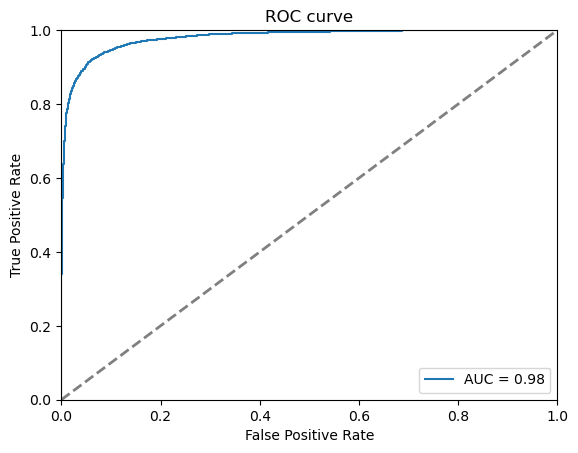

In [71]:
display.plot()
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.title('ROC curve')
plt.margins(0)
plt.show()

The model has an AUC of 0.98, which is  very close to 1 and indicates great performance of the model on an unseen data.

### Error analysis

We look into the top 5 comments that were predicted wrongly with the highest confidence score in order to see what might have gone wrong in our model.

In [72]:
decision_func_list = svc.decision_function(X_test_tfidf)
decision_func_list

array([-1.1895522 , -1.53268329, -0.73969193, ..., -1.15329207,
        0.90806727,  1.43696907])

In [73]:
decision_func_abs = np.absolute(decision_func_list)
decision_func_abs

array([1.1895522 , 1.53268329, 0.73969193, ..., 1.15329207, 0.90806727,
       1.43696907])

In [74]:
error_idx = [idx for idx, (i, j) in enumerate(zip(y_test, y_hat)) if i!=j]

In [75]:
error_idx_sorted = [idx for abs, idx in sorted(zip(decision_func_abs[error_idx],error_idx), reverse=True)]

In [76]:
correct_idx = [idx for idx, (i, j) in enumerate(zip(y_test, y_hat)) if i==j]

In [77]:
correct_idx_sorted = [idx for abs, idx in sorted(zip(decision_func_abs[correct_idx],correct_idx), reverse=True)]

In [78]:
# Top 5 wrong prediction
for idx in error_idx_sorted[:5]:
    print(X_test[idx])
    print("true label: ", y_test[idx])
    print("predicted label: ", y_hat[idx])
    print("decision_func_score: ", decision_func_list[idx])
    print("=============================="*2)

I was really excited to try this product based on the reviews. I loved everything about it - scent, texture etc. Sadly, it caused me to breakout all over my face and I had to stop using it.
true label:  1.0
predicted label:  0.0
decision_func_score:  -1.8769531027651776
it’s really good but so overrated like there’s nothing special about it, not worth the money tbh
true label:  1.0
predicted label:  0.0
decision_func_score:  -1.7539652142534625
This product didn’t work for my skin personally, but if you have dry normal skin this would work for you. I have combo acne prone skin and the first couple weeks of use it was amazing but then I started to notice it was clogging the pores on my cheeks and gave me milia bumps near my under eye area. It’s a heavier cream, and you don’t need that much product to cover your face. It kind of takes a while to sink into the skin, I used this as a nighttime cream for that reason.
true label:  1.0
predicted label:  0.0
decision_func_score:  -1.6987861582

**Review 1**: The reviewer expresses enthusiasm for the product's features but ultimately reports a negative experience (breakouts) and stops using it. The true label of 1 might indicate a labeling error, as the overall sentiment skews negative due to the skin reaction. Alternatively, the model might have been confused by the initially positive language and missed the shift in sentiment when the reviewer mentioned the product’s adverse effects.

**Review 2**: The reviewer acknowledges that the product is good but criticizes it for being overrated and not worth the price. This mixed review, while mostly critical, is labeled as 1 (recommendation), possibly suggesting a labeling error. 

**Review 3**: The reviewer provides a detailed account of how the product didn’t suit their skin type but could work for others, and thus recommending it for others. The mention of positive effects at first might have led to the true label being 1, but the model likely focused on the later negative experiences (clogging pores, milia bumps), causing it to predict 0.

**Review 4**: The reviewer describes their persistent lip problem and frustration with the product not resolving the issue, concluding they will never buy it again. The true label of 0 seems accurate, but the model might have been misled by phrases like “recommend this sleep mask” and the initial hopeful tone, resulting in a predicted label of 1.

**Review 5**: This reviewer explains that they don’t personally need the product but uses it for someone else who loves it. The mixed nature of the review, with neutral-to-positive language about its effectiveness for another person, could have confused the model. The true label of 0 aligns with the reviewer's own indifference, but the model might have focused on the positive remarks about the husband’s experience, leading to a prediction of 1.

### feature importance

In [79]:
# The 30 most importat features in the model
for score, fname in sorted(zip(svc.coef_[0], feature_names), reverse=True)[:30]:
    print(fname, score)

love 3.018676816766791
amazing 2.4822452064217586
soft 2.4522948926712664
best 2.330892758120321
gentle 2.0942405632605006
skeptical 2.0082396223414434
great 1.9881102114210054
cucumber 1.96608375191186
perfect 1.9654685124150009
without 1.8970390552304113
winter 1.867280910599554
smooth 1.8094471059813024
saved 1.7997996219661097
helped 1.7241558548562566
helps 1.662683905357922
lips 1.6609695006724021
obsessed 1.6303165813126217
keeps 1.5380898238818383
eczema 1.5166241499323414
years 1.5099653380528613
night 1.5013882598372295
favorite 1.49174576728599
vanilla 1.4795311312131785
fresh 1.462015247776052
lipstick 1.428203458083405
wonders 1.4187904437242096
softer 1.3889684366526602
lip 1.3580803005715656
awesome 1.3436194319425643
soothing 1.3339702454916191


Observing the 30 most important features, words having strong and clear meaning such as "love", "amazing", "best", "skeptical", and "great" generally had strong importance in the model, which is very reasonable since those words give clearer information and tone of the reviews. 